In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import Union

In [2]:
H, W, f = 400, 400, 1200

### Extrinsic Camera Matrix

$$
\begin{align*}
[R|\mathbf{t}] &= \left[
\begin{array}{ccc|c}
r_{11} & r_{12} & r_{13} & t_1 \\
r_{21} & r_{22} & r_{23} & t_2 \\
r_{31} & r_{32} & r_{33} & t_3 \\
\end{array}
\right] \\
\left[\begin{array}{c|c}
R & \mathbf{t} \\
\hline 0 & 1 
\end{array}\right] &= 
\left[\begin{array}{c|c}
I & \mathbf{t} \\
\hline 0 & 1 
\end{array}\right]
\left[\begin{array}{c|c}
R & 0 \\
\hline 0 & 1 
\end{array}\right] \\
  \left[
\begin{array}{ccc|c}
r_{11} & r_{12} & r_{13} & t_1 \\
r_{21} & r_{22} & r_{23} & t_2 \\
r_{31} & r_{32} & r_{33} & t_3 \\
\hline 0& 0 & 0 & 1
\end{array}
\right] &=
\left[
\begin{array}{ccc|c}
1 & 0 & 0 & t_1 \\
0 & 1 & 0 & t_2 \\
0 & 0 & 1 & t_3 \\
\hline 0& 0 & 0 & 1
\end{array}
\right]
\left[
\begin{array}{ccc|c}
r_{11} & r_{12} & r_{13} & 0 \\
r_{21} & r_{22} & r_{23} & 0 \\
r_{31} & r_{32} & r_{33} & 0 \\
\hline 0& 0 & 0 & 1
\end{array}
\right]
\end{align*}
$$

- https://ksimek.github.io/2012/08/22/extrinsic/

In [3]:
c2w1 = np.array([0.34303784370422363, -0.8594792485237122,
                 0.3789729177951813, 3.7897279262542725,
                 0.9393215775489807, 0.3138796091079712,
                 -0.13839992880821228, -1.3840025663375854,
                 0.0, 0.40345385670661926,
                 0.9150000214576721, 9.149999618530273,
                 0.0, 0.0, 0.0, 1.0])
c2w1 = c2w1.reshape((4, 4))
c2w2 = np.array([-0.7053813934326172, -0.5776947736740112,
                0.41073814034461975, 4.1073899269104,
                0.7088279724121094, -0.5748858451843262,
                0.4087409973144531, 4.087401390075684,
                0.0, 0.5794609785079956,
                0.8149999976158142, 8.149999618530273,
                0.0, 0.0, 0.0, 1.0])
c2w2 = c2w2.reshape((4, 4))
print(c2w1)
print(c2w2)

[[ 0.34303784 -0.85947925  0.37897292  3.78972793]
 [ 0.93932158  0.31387961 -0.13839993 -1.38400257]
 [ 0.          0.40345386  0.91500002  9.14999962]
 [ 0.          0.          0.          1.        ]]
[[-0.70538139 -0.57769477  0.41073814  4.10738993]
 [ 0.70882797 -0.57488585  0.408741    4.08740139]
 [ 0.          0.57946098  0.815       8.14999962]
 [ 0.          0.          0.          1.        ]]


In [4]:
def ray_trace(H, W, c2w):
    '''
    H: height of the image
    W: width of the image
    c2w: camera world matrix (extrinsic camera matrix)
    '''
    rays_o = np.zeros((H*W,3))
    rays_d = np.zeros((H*W,3))
    u = np.arange(H)
    v = np.arange(W)
    u,v = np.meshgrid(u,v)
    dirs = np.stack(((u-W/2), 
                   -(v-H/2),
                   -np.ones_like(u)*f), 
                    axis=-1) # depth fo focal length
    dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
    rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
    rays_d = rays_d.reshape(-1, 3)

    rays_o += c2w[:3, 3]
    return rays_o, rays_d

In [5]:
class Sphere():
    def __init__(self, p, r, c):
        '''
        p position of the sphere
        r radius 
        c color
        '''
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        '''
        o origin of the ray
        d direction of ray
        '''
        a = 0
        for i in range(3):
            a+=(x[:,i]-self.p[i])**2
        cond = a<=self.r**2
        
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays,3))
        density = torch.zeros((num_rays,1))
        colors[cond] = self.c
        density[cond] = 10
        
        color_condition = x[:, 0] < 0
        tmp = colors[color_condition, 0].clone()
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        colors[color_condition, 1] = tmp
        
        return colors, density
    
    def locate(self, o=None, d=None, t=1, every=100):
        o = o.numpy()
        d = d.numpy()
        fig = plt.figure(figsize=(12,12))
        ax = plt.axes(projection='3d')
        p = self.p.numpy()
        
        if o is not None or d is not None:
            pt1 = o
            pt2 = o+t*d
            show1 = np.vstack((pt1[::every],pt1[-1]))
            show2 = np.vstack((pt2[::every],pt2[-1]))
#             print(show1.shape, pt1[-1].shape)
#             print(np.vstack((show1,pt1[-1])).shape)

            for p1,p2 in zip(show1, show2):
                ax.plot([p1[0],p2[0]],
                        [p1[1],p2[1]],
                        [p1[2],p2[2]])
        
        u,v = np.mgrid[-np.pi:np.pi:50j,0:np.pi:50j]
#         print(u[:10,:10])
        x = self.r*np.cos(u)*np.sin(v)
        y = self.r*np.sin(u)*np.sin(v)
        z = self.r*np.cos(v)
        ax.plot_surface(x, y, z, 
                        color=self.c.numpy(), 
                        alpha=0.5*np.random.random()+0.5)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(90, 270)
#         ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
#         ax.set_box_aspect(aspect = (1,1,1))
        ax.auto_scale_xyz([-4,4], [-4,4], [-4,8])

        plt.show()

In [6]:
def rendering(model,
              rays_o, 
              rays_d, 
              tn: Union[float,int], 
              tf: Union[float,int], 
              nb_bins:int=100, 
              device:str='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device)
    # nb_bins
    delta = torch.cat((t[1:]-t[:-1], 
                      torch.tensor([1e10])))
    # [nb_rays, nb_bins, 3]
    r = rays_o.unsqueeze(1) + \
        t.unsqueeze(0).unsqueeze(-1)*rays_d.unsqueeze(1) 
    colors, density = model.intersect(r.reshape(-1,3))
    # [nb_rays, nb_bins, 3]
    colors = colors.reshape((r.shape[0], nb_bins, 3))
    density = density.reshape((r.shape[0], nb_bins))
    # [nb_rays, nb_bins]
    alpha = 1-torch.exp(-density*delta.unsqueeze(0)) 
    T = torch.cumprod(1-alpha, 1) # [nb_rays, nb_bins]
#     print(T)
    T[:, 1:] = T[:, :-1]
    T[:, 0] = 1
#     print(T)
    # [nb_rays, 3]
    c = (T.unsqueeze(-1)*alpha.unsqueeze(-1)*colors).sum(1) 
#     print(c.shape)
    
    return c

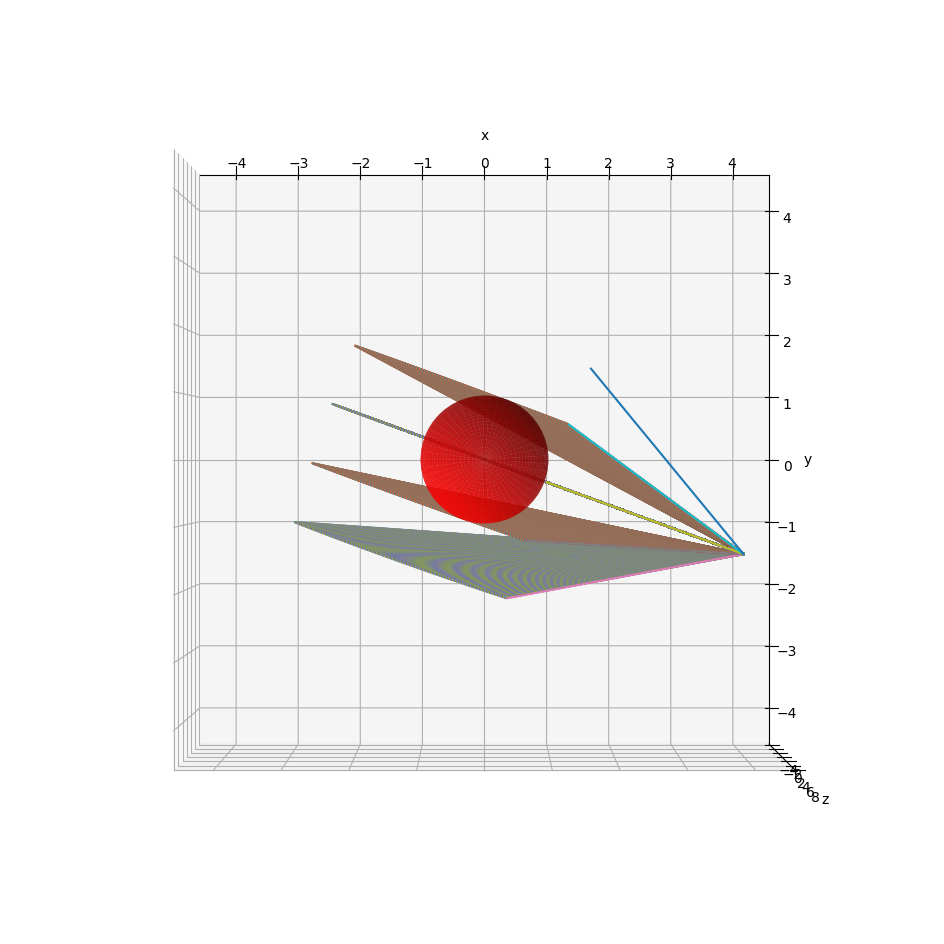

In [7]:
rays_o, rays_d = ray_trace(H, W, c2w1)
s = Sphere(torch.tensor([0, 0, 0]),
          1,
          torch.tensor([1.,0.,0.]))
px_colors = rendering(s, 
        torch.from_numpy(rays_o), 
        torch.from_numpy(rays_d), 8, 12)
s.locate(o=torch.from_numpy(rays_o), 
         d=torch.from_numpy(rays_d), 
         t=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


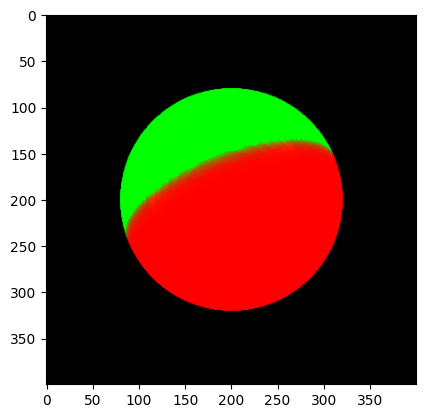

In [8]:
img = px_colors.reshape(H, W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)
plt.show()

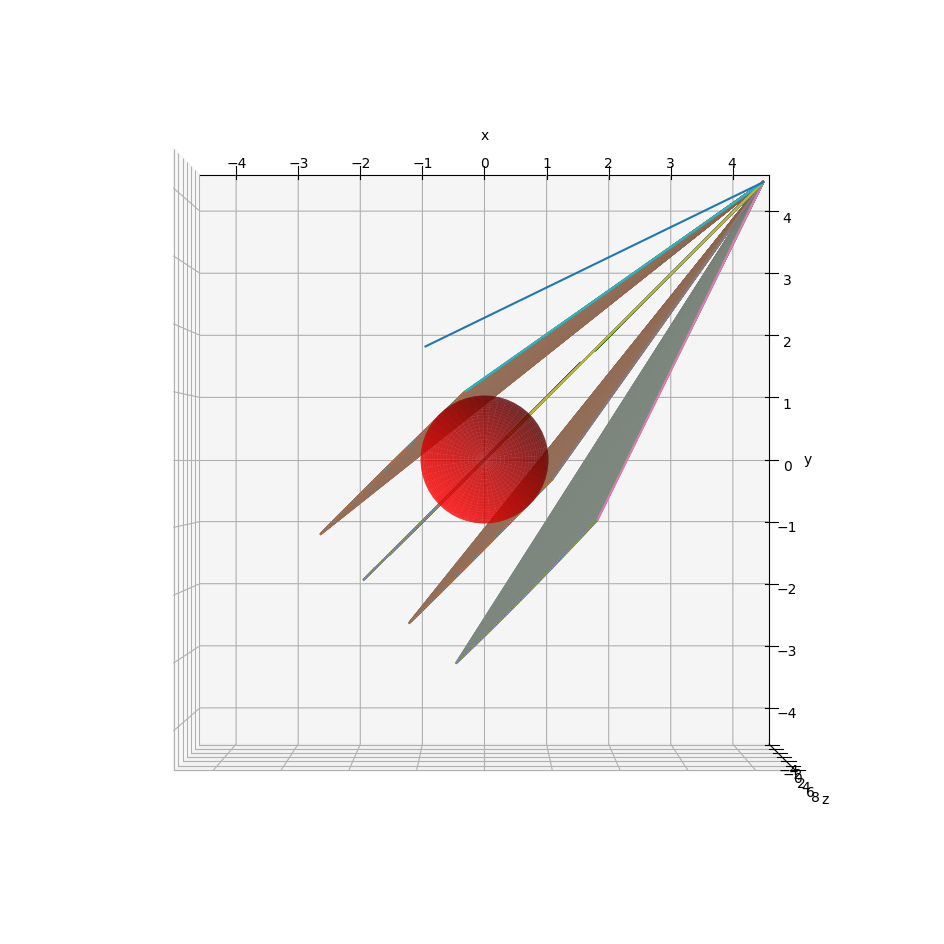

In [9]:
rays_o, rays_d = ray_trace(H, W, c2w2)
s = Sphere(torch.tensor([0, 0, 0]),
          1,
          torch.tensor([1.,0.,0.]))
px_colors = rendering(s, 
        torch.from_numpy(rays_o), 
        torch.from_numpy(rays_d), 8, 12)
s.locate(o=torch.from_numpy(rays_o), 
         d=torch.from_numpy(rays_d), 
         t=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


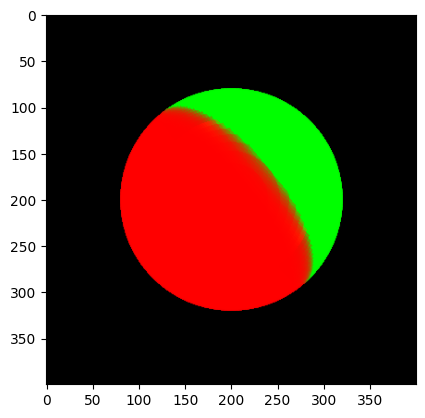

In [10]:
img = px_colors.reshape(H, W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)
plt.show()